In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             log_loss, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, precision_recall_curve, auc,
                             DetCurveDisplay, ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

## **Data Cleaning & Exploration**

- The training set contains 45,211 observations and 18 features. 

- The test set is a 10% random subset of the training set. 

- The data consists of numeric and categorical data. Both data sets contain no missing values. 

- Some categorical variables contained unknown values mainly for the outcome of the previous marketing campaign. 

- The dependent variable was converted to a binary variable to model the outcome. 

- Analysis of the class distribution for the dependent variable showed a large class imbalance with ~11% of clients who subscribed to a term deposit. 

- A chi-square test of independence was completed to examine the relationship between job type and subscription outcome. 

- While all job categories exhibited more non-subscribers than subscribers, reflecting the overall class imbalance in the data, there were differences across job type. 

- Students and retirees showed *higher subscription rates (28.7% and 22.8%) compared to other job types*. 

- The chi-square test gave a statistically significant result (χ² = 836.11, p < 0.01) providing strong evidence that job type and subscribing to a term deposit are related, and that job type is potentially predictive.

In [42]:
# loading data sets
df_train = pd.read_csv('train.csv', delimiter = ';')
df_test = pd.read_csv('test.csv', delimiter = ';')

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [45]:
print(f"Training Set NaNs\n{df_train.isnull().sum()}")
print(f"Test Set NaNs\n{df_test.isnull().sum()}") # checking for NaN and nulls

Training Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Test Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [46]:
# checking for 'unknown' values in categorical columns in training set
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unknown_count = (df_train[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
y: 0


In [47]:
# checking for 'unknown' values in categorical columns in test set
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        unknown_count = (df_test[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

job: 38
marital: 0
education: 187
default: 0
housing: 0
loan: 0
contact: 1324
month: 0
poutcome: 3705
y: 0


In [48]:
# exploring class distribution of dependent variable
dic = {'no': 0, 'yes': 1} # creating binary dictionary for response variable

df_train['y'] = df_train['y'].map(dic)
df_test['y'] = df_test['y'].map(dic)

In [49]:
print(f"Mean of training set response variable classes {df_train['y'].mean()}")

Mean of training set response variable classes 0.11698480458295547


In [50]:
print(f"Mean of test set response variable classes {df_test['y'].mean()}")

Mean of test set response variable classes 0.11523999115239991


In [51]:
contingency_table = pd.crosstab(df_train['job'], df_train['y']) # creating contingency table
print(contingency_table)

y                 0     1
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34


In [52]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"chi-squared statistic {chi2}")
print(f"p-value {p_value}")
print(f"df {dof}")

chi-squared statistic 836.1054877471965
p-value 3.337121944935502e-172
df 11


## **Baseline Models**

In [53]:
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

In [54]:
cat_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_feats = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

#### **Logistic Regression Model**

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ]
)

lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr.fit(X_train, y_train)

pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:, 1]

In [71]:
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)  
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.5920
Recall: 0.1420


#### **k-Nearest Neighbours Model**

In [ ]:
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)


pred_knn = knn.predict(X_test)

In [58]:
precision_knn = precision_score(y_test, pred_knn, pos_label=1)
recall_knn = recall_score(y_test, pred_knn, pos_label=1)
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")

Precision: 0.7110
Recall: 0.2975


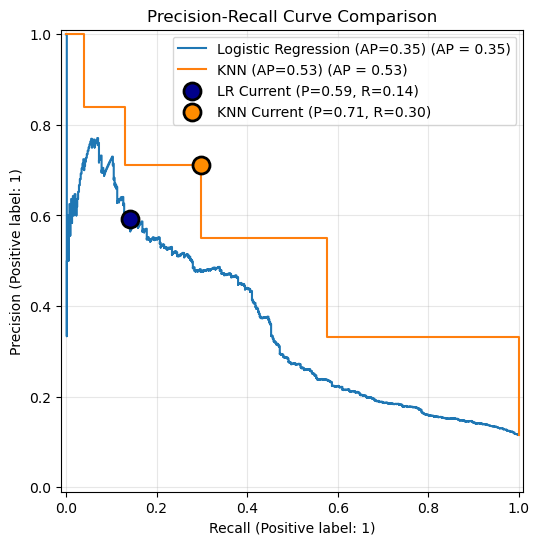

In [ ]:
ap_lr = average_precision_score(y_test, lr.predict_proba(X_test)[:, 1])
ap_knn = average_precision_score(y_test, knn.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots(figsize=(12,6))

PrecisionRecallDisplay.from_estimator(
    lr, X_test, y_test,
    name=f'Logistic Regression (AP={ap_lr:.2f})',
    ax=ax
)

PrecisionRecallDisplay.from_estimator(
    knn, X_test, y_test, 
    name=f'KNN (AP={ap_knn:.2f})',
    ax=ax
)

ax.scatter(recall, precision, color='darkblue', s=150, marker='o', 
           edgecolors='black', linewidths=2,
           label=f'LR Current (P={precision:.2f}, R={recall:.2f})', zorder=5)
ax.scatter(recall_knn, precision_knn, color='darkorange', s=150, marker='o', 
           edgecolors='black', linewidths=2,
           label=f'KNN Current (P={precision_knn:.2f}, R={recall_knn:.2f})', zorder=5)

plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### **Baseline Model Evaluation**
- Logistic regression had higher precision than recall (over 4x) and k-NN had higher precision than recall (more than 2x). By using these models, running another telemarketing campaign can capture a segment of our clients who will leave term deposits somewhat efficiently, however we would miss a chunk of clients who would have also subscribed to more term deposits.

- Advantages of higher precision than recall are if we have budget constraints for our telemarketing campaign and want to reduce the risk of losing customers do to false positive cases. 

## **Ensemble Modelling**

In [81]:
# random forest
rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1))
])

# adaboost
ada = Pipeline([
    ('prep', preprocessor),
    ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                               n_estimators=300, learning_rate=0.5, random_state=42))
])

# bagging classifier
bag = Pipeline([
    ('prep', preprocessor),
    ('bag', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, 
                              max_samples=0.8, bootstrap=True, n_jobs=-1, random_state=42))
])

# voting classifier
vote = Pipeline([
    ('prep', preprocessor),
    ('clf', VotingClassifier(estimators=[
        ('bag', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, 
                                  max_samples=0.8, bootstrap=True, n_jobs=-1, random_state=42)),
        ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                   n_estimators=300, learning_rate=0.5, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1))
    ], voting='soft'))  # Added closing parenthesis here and voting parameter
])

In [82]:
models = {
    'RandomForest': rf, 
    'AdaBoost': ada, 
    'Bagging': bag, 
    'Voting': vote
}

In [85]:
# 5-Fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy', 
    'roc_auc': 'roc_auc', 
    'f1': 'f1', 
    'precision': 'precision', 
    'recall': 'recall', 
    'neg_log_loss': 'neg_log_loss'
}

# Cross-validation results
cv_rows = []

In [88]:
for name, pipe in models.items():
    print(f"Cross-validating {name}...")
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_rows.append({
        'model': name,
        'acc_mean': res['test_accuracy'].mean(),
        'auc_mean': res['test_roc_auc'].mean(),
        'f1_mean': res['test_f1'].mean(),
        'prec_mean': res['test_precision'].mean(),
        'recall_mean': res['test_recall'].mean(),
        'logloss_mean': -res['test_neg_log_loss'].mean()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("auc_mean", ascending=False)
print("\nCross-Validation Results:")
print(cv_df)

Cross-validating RandomForest...
Cross-validating AdaBoost...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Cross-validating Bagging...
Cross-validating Voting...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana


Cross-Validation Results:
          model  acc_mean  auc_mean   f1_mean  prec_mean  recall_mean  \
3        Voting  0.894185  0.789627  0.284031   0.679598     0.179619   
0  RandomForest  0.894207  0.784948  0.329637   0.636392     0.222537   
1      AdaBoost  0.892504  0.782983  0.341472   0.602139     0.238421   
2       Bagging  0.893168  0.740174  0.282531   0.657991     0.179997   

   logloss_mean  
3      0.369539  
0      0.308678  
1      0.682189  
2      0.316987  



Training RandomForest...
RandomForest - Precision: 1.0000, Recall: 1.0000

Training AdaBoost...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Precision: 0.6715, Recall: 0.2668

Training Bagging...
Bagging - Precision: 0.6639, Recall: 0.1516

Training Voting...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Voting - Precision: 0.9854, Recall: 0.2591


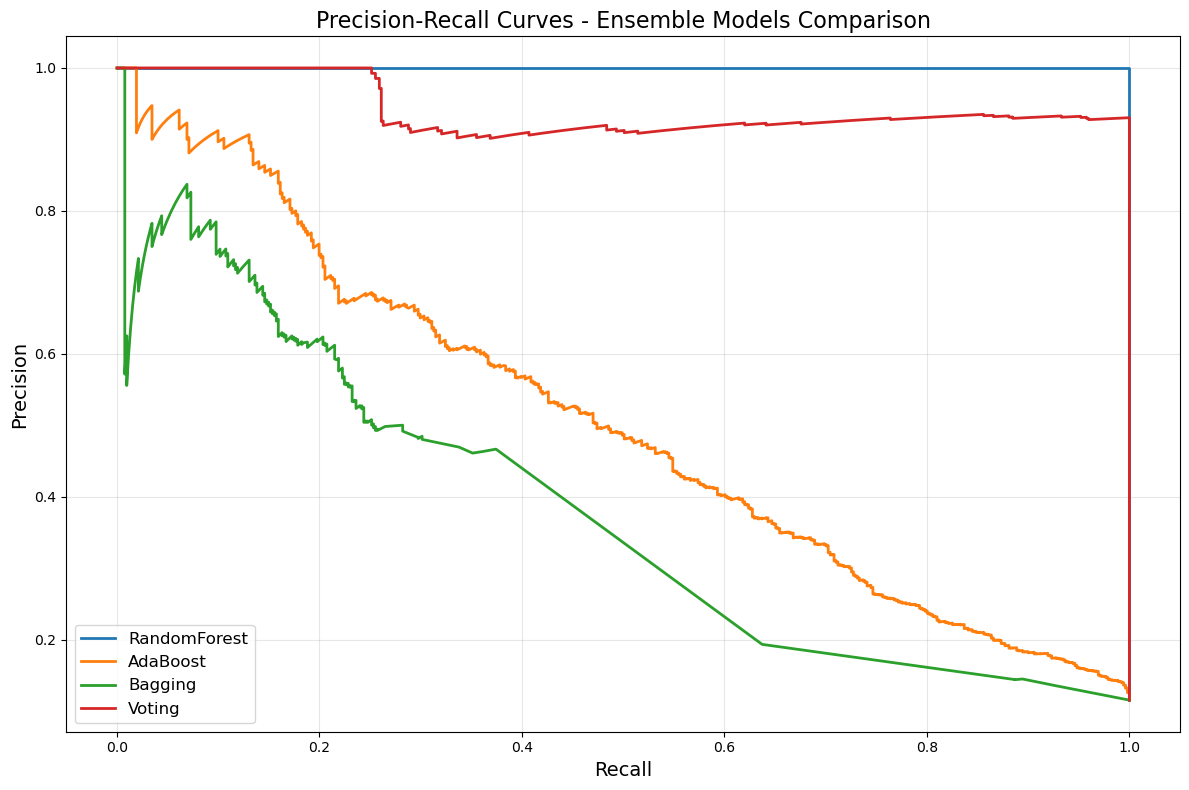


Test Set Results Summary:
          model  precision    recall
0  RandomForest   1.000000  1.000000
3        Voting   0.985401  0.259117
1      AdaBoost   0.671498  0.266795
2       Bagging   0.663866  0.151631


In [90]:
test_results = []
plt.figure(figsize=(12, 8))

for name, pipe in models.items():
    print(f"\nTraining {name}...")
    
    # Fit the model
    pipe.fit(X_train, y_train)
    
    # Predictions
    pred = pipe.predict(X_test)
    pred_proba = pipe.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    test_results.append({
        'model': name,
        'precision': precision,
        'recall': recall
    })
    
    print(f"{name} - Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, pred_proba)
    plt.plot(recall_curve, precision_curve, linewidth=2, label=f'{name}')

# Finalize plot
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves - Ensemble Models Comparison', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Test results dataframe
test_df = pd.DataFrame(test_results).sort_values('precision', ascending=False)
print("\nTest Set Results Summary:")
print(test_df)